# Setup imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from collections import defaultdict, Counter
import os
from tqdm import tqdm
import pickle
from contextlib import nullcontext
import tiktoken
import logomaker

from nanoGPT.model import GPTConfig, GPT
from vqvae_model import VQVAE

/Users/suyashshringarpure/Work/mnist_vlm/venv/lib/python3.9/site-packages/logomaker/../urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Set up constants and other parameters

In [2]:
# Setup as in the nanoGPT sample.py script
seed = 1337
device = 'cpu'
temperature = 0.8
top_k = 200
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32' or 'bfloat16' or 'float16'
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)

# Functions for setting up models and metadata

## Function for vision language model (VLM) checkpoint loading

In [3]:
def setup_model_and_meta(out_dir,fname,device=device):
    ckpt_path = os.path.join(out_dir, fname)
    checkpoint = torch.load(ckpt_path, map_location=device,weights_only=False)
    gptconf = GPTConfig(**checkpoint['model_args'])
    model = GPT(gptconf)
    state_dict = checkpoint['model']
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict)
    model.eval()
    model.to(device)

    meta_path = os.path.join('nanoGPT','data', checkpoint['config']['dataset'], 'meta.pkl')
    with open(meta_path, 'rb') as f:
        meta = pickle.load(f)
    # TODO want to make this more general to arbitrary encoder/decoder schemes
    stoi, itos = meta['stoi'], meta['itos']
    encode = lambda s: [stoi[c] for c in s]
    decode = lambda l: ''.join([itos[i] for i in l])
    
    return model,encode,decode

## Function for VQVAE model loading

In [4]:
def setup_vqvae():
    input_dim = 28  # Input dimension (1 channel for grayscale images)
    hidden_dim = 128  # Hidden layer size
    latent_dim = 32  # Latent space dimensionality
    num_embeddings = 26  # Number of embedding vectors in the codebook
    quantization_embedding_dim = 4 
    commitment_cost = 0.25  # Weight for the commitment loss
    batch_size = 128  # Batch size for training
    learning_rate = 1e-3  # Learning rate for optimizer
    
    vqvae_model = VQVAE(input_dim, hidden_dim, latent_dim, num_embeddings, 
                        quantization_embedding_dim, commitment_cost, learning_rate)  # Initialize VQ-VAE model
    vqvae_model.load_state_dict(torch.load("vqvae_mnist_final_model.pth",
                                     weights_only=True))
    vqvae_model.eval()
    vqvae_model.quantizer.initialized = True
    return vqvae_model

## Function for sampling VLM outputs for multiple prompts

In [5]:
def multi_prompt_sampling(model,examples,encode,decode,device=device,max_new_tokens=10):
    answer_list = []
    for example in tqdm(examples,desc="Processing examples",total=len(examples)):
        start_ids = encode(example.strip())
        x = (torch.tensor(start_ids, dtype=torch.long, device=device)[None, ...])
        # run generation
        with torch.no_grad():
            with ctx:
                y = model.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
                answer_list.append(decode(y[0].tolist()))
    return answer_list

## Function to extract image tokens. numeric label, and masked prompt for input to LLM

In [6]:
def get_image_and_label(x,type='classification'):
    masked = ":".join(x.split(":")[:-1]) + ":"
    x = x.split(".")[0].replace(",","").replace(":"," ")
    fields = x.split()

    if type=='classification':
        img, label = fields[1], fields[-1]
    else:
        img, label = fields[-1], fields[1]
    return (img,label,masked)

## Function to reconstruct image from image tokens (VQVAE decoding)

In [7]:
def get_reconstruction(vqvae_model, letterstr):
    try:
        with torch.no_grad():
            indices = torch.tensor([ord(x) - ord('A') for x in list(letterstr)])
            quantized = vqvae_model.quantizer.embedding(indices).view(1,-1)
            recon = vqvae_model.decoder(quantized).numpy().squeeze()
    except IndexError as e:
        recon = np.zeros((28,28))
    return recon

## Load VQVAE and the latest VLM checkpoint

In [8]:
# VQVAE model loading
vqvae_model = setup_vqvae()

In [9]:
# VLM loading
model,encode,decode = setup_model_and_meta("./nanoGPT/out-mnist-vlm/","ckpt_5000.pt")

number of parameters: 14.18M


# Visualize image tokenization in training examples

## Helper functions for visualization

### Generate a color scheme dictionary for A-Z

In [10]:
def create_color_scheme():
    # Define a list of 26 distinct color names or hex codes
    color_palette = [
        'blue', 'orange', 'green', 'red', 'purple', 'brown', 'pink', 'gray',
        'olive', 'cyan', '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
        '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#e41a1c',
        '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#222211'
    ]
    
    # Map each letter to a color
    letters = [chr(i) for i in range(ord('A'), ord('Z') + 1)]  # A-Z
    color_scheme = {letter: color_palette[i % len(color_palette)] for i, letter in enumerate(letters)}
    
    return color_scheme

# Create the color scheme
color_scheme = create_color_scheme()

### Function to create a frequency DataFrame for a given digit

In [11]:
def create_frequency_df(strings,max_positions=None):
    string_length = len(strings[0])
    position_frequencies = []
    for pos in range(string_length):
        col = [string[pos] for string in strings]  # Collect letters at this position
        counts = Counter(col)
        # Convert counts to relative frequencies
        total = sum(counts.values())
        freqs = {char: count / total for char, count in counts.items()}
        position_frequencies.append(freqs)
    df = pd.DataFrame(position_frequencies).fillna(0)
    if max_positions is not None:
        df = df.iloc[:max_positions]
    df.index.name = "Position"
    return df

## Load training data

In [12]:
trainfile = "./nanoGPT/data/mnist_vlm/train.txt"
trainlist = open(trainfile).readlines()[:1000]
train_classifn_egs = [get_image_and_label(x,type='classification') if x.startswith('image') else \
                      get_image_and_label(x,type='generation') for x in trainlist ]
train_generation_dict = defaultdict(list)
for image,label,_ in train_classifn_egs:
    train_generation_dict[label].append(image)

## Generate grid of logoplots for all digits

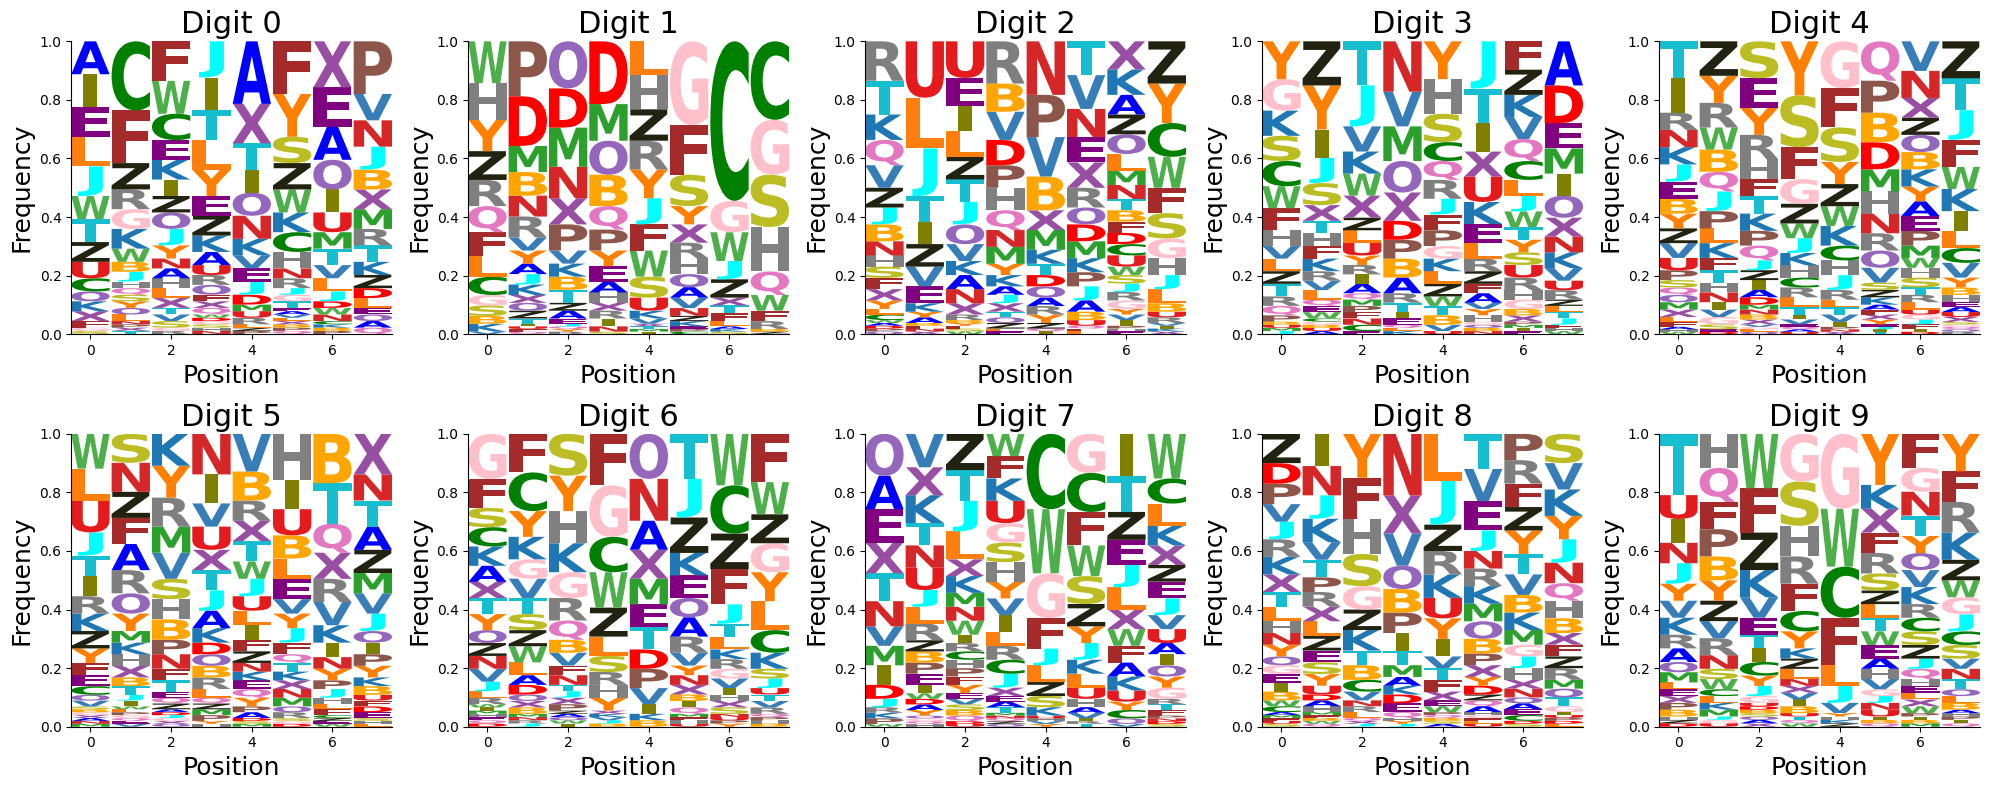

In [13]:
# Create the combined plot
fig, axes = plt.subplots(2, 5, figsize=(20, 8))  # 2 rows x 5 columns grid
axes = axes.flatten()  # Flatten the axes array for easier iteration

for i, digit in enumerate(range(10)):
    strings = train_generation_dict[str(digit)]
    freq_df = create_frequency_df(strings,max_positions=8)  # Get frequency DataFrame for the digit
    
    # Create a logomaker logo on the corresponding subplot
    logomaker.Logo(freq_df, ax=axes[i], color_scheme=color_scheme)
    
    # Add title to each subplot
    axes[i].set_title(f"Digit {digit}", fontsize=22)
    axes[i].set_xlabel("Position", fontsize=18)
    axes[i].set_ylabel("Frequency", fontsize=18)
    
    # Hide spines for a cleaner look
    axes[i].spines['top'].set_visible(False)
    axes[i].spines['right'].set_visible(False)

# Adjust layout to avoid overlap
plt.tight_layout()
plt.savefig("image_token_plot.png")
plt.show()


## Load test data

In [14]:
testfile = "./nanoGPT/data/mnist_vlm/test.txt"
testlist = open(testfile).readlines()

## Split test examples into classification and image generation

In [15]:
# We only keep 1000 examples for faster evaluation and visualization
classifn_egs = [get_image_and_label(x,type='classification') for x in testlist if x.startswith('image')][:1000]
generation_egs = [get_image_and_label(x,type='generation') for x in testlist if x.startswith('number')][:1000]

# Evaluation for classification task

In [16]:
# Look at a few examples as a sanity check
masked_classifn_egs = [x[2] for x in classifn_egs]
labels_classifn_egs = np.array([x[1] for x in classifn_egs])
print(masked_classifn_egs[:3])

['image:ZPODZSCC, number:', 'image:ELPHZPAJ, number:', 'image:TRNWZEFR, number:']


In [17]:
classifn_preds_raw = multi_prompt_sampling(model,masked_classifn_egs,encode,decode)

Processing examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:07<00:00, 14.88it/s]


In [18]:
classifn_preds = np.array([x.split(".")[0].split(":")[-1] for x in classifn_preds_raw])

In [19]:
prediction_accuracy = np.mean(labels_classifn_egs == classifn_preds)
print(f"Prediction accuracy={prediction_accuracy}")

Prediction accuracy=0.932


## Look at common error patterns in the confusion matrix

In [20]:
confusion = pd.crosstab(labels_classifn_egs,classifn_preds)
confusion = confusion/confusion.sum(axis=0) # Normalize per row
confusion[(confusion > 0.03) & (confusion < 0.8)].stack().reset_index().sort_values(by=0,ascending=False)

,row_0,col_0,0
2,4,9,0.074468
5,7,9,0.053191
3,5,3,0.042017
4,7,2,0.034483
6,8,2,0.034483
0,2,3,0.033613
1,3,7,0.033333
7,9,7,0.033333


## Check model performance over training iterations

In [21]:
ckpts = [x*500 for x in [1] + list(range(2,11,2))]
accuracy_list = []
se_list = []
for ckpt in ckpts:
    print(ckpt)
    model,encode,decode = setup_model_and_meta("./nanoGPT/out-mnist-vlm/",f"ckpt_{ckpt}.pt")
    classifn_preds_raw = multi_prompt_sampling(model,masked_classifn_egs,encode,decode)
    classifn_preds = np.array([x.split(".")[0].split(":")[-1] for x in classifn_preds_raw])
    prediction_accuracy = np.mean(labels_classifn_egs == classifn_preds)
    accuracy_list.append(prediction_accuracy)
    se_list.append(np.sqrt(prediction_accuracy*(1-prediction_accuracy)/len(labels_classifn_egs)))

500
number of parameters: 14.18M


Processing examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:08<00:00, 14.67it/s]


1000
number of parameters: 14.18M


Processing examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:07<00:00, 14.80it/s]


2000
number of parameters: 14.18M


Processing examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:25<00:00, 11.66it/s]


3000
number of parameters: 14.18M


Processing examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:06<00:00, 15.07it/s]


4000
number of parameters: 14.18M


Processing examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:02<00:00, 15.91it/s]


5000
number of parameters: 14.18M


Processing examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:19<00:00, 12.60it/s]


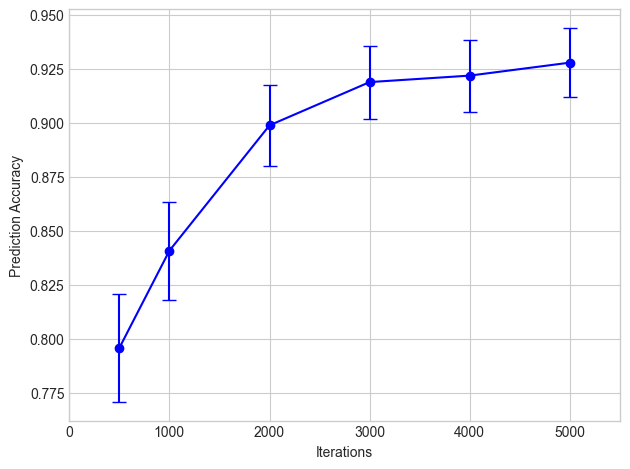

In [22]:
errors = 1.96*np.array(se_list)
plt.style.use('seaborn-v0_8-whitegrid')
plt.errorbar(ckpts, accuracy_list, yerr=errors, fmt='o-', color='b', ecolor='b', capsize=5)
plt.xlim(0,5500)
plt.xlabel('Iterations')
plt.ylabel('Prediction Accuracy')
plt.tight_layout()
plt.savefig("prediction_accuracy_plot.png")
plt.show()

# Evaluation for image generation task

In [23]:
masked_generation_egs = [x[2] for x in generation_egs]
labels_generation_egs = np.array([x[1] for x in generation_egs])
print(masked_generation_egs[:3])

['number:7, image:', 'number:2, image:', 'number:0, image:']


## Function to plot all reconstructions in one grid

In [24]:
def plot_all_predictions(generation_dict, vqvae_model, max_plots_per_digit=25):
    all_digits = list(range(10))
    reconlist = []
    
    # Determine the grid size for 10 rows (one per digit)
    grid_size_per_row = max_plots_per_digit #int(np.ceil(np.sqrt(max_plots_per_digit)))
   # total_grid_size = len(all_digits) * grid_size_per_row  # Total rows needed
    
    fig, axes = plt.subplots(len(all_digits), grid_size_per_row, figsize=(grid_size_per_row * 1.1, len(all_digits) * 1.1))
    
    for label_num in all_digits:
        tokenlist = generation_dict[str(label_num)]
        plotlist = tokenlist[:max_plots_per_digit]
        
        for idx, tokenstr in enumerate(plotlist):
            row = label_num  # Row corresponds to the digit
            col = idx  # Column index within the row
            
            ax = axes[row, col]
            recon = get_reconstruction(vqvae_model, tokenstr)
            reconlist.append(recon)
            ax.imshow(recon, cmap='gray')  # Plot the image
            ax.axis('off')
        
        # Hide unused subplots in the current row
        for idx in range(len(plotlist), grid_size_per_row):
            col = idx  # Extra columns
            ax = axes[row, col]
            ax.axis('off')
    
    # Add overall adjustments
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    return reconlist,plt

## Plot generations for model from iteration 500

In [25]:
model,encode,decode = setup_model_and_meta("./nanoGPT/out-mnist-vlm/","ckpt_500.pt")
generation_preds_raw_first = multi_prompt_sampling(model, masked_generation_egs,encode,decode)

number of parameters: 14.18M


Processing examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:16<00:00, 13.11it/s]


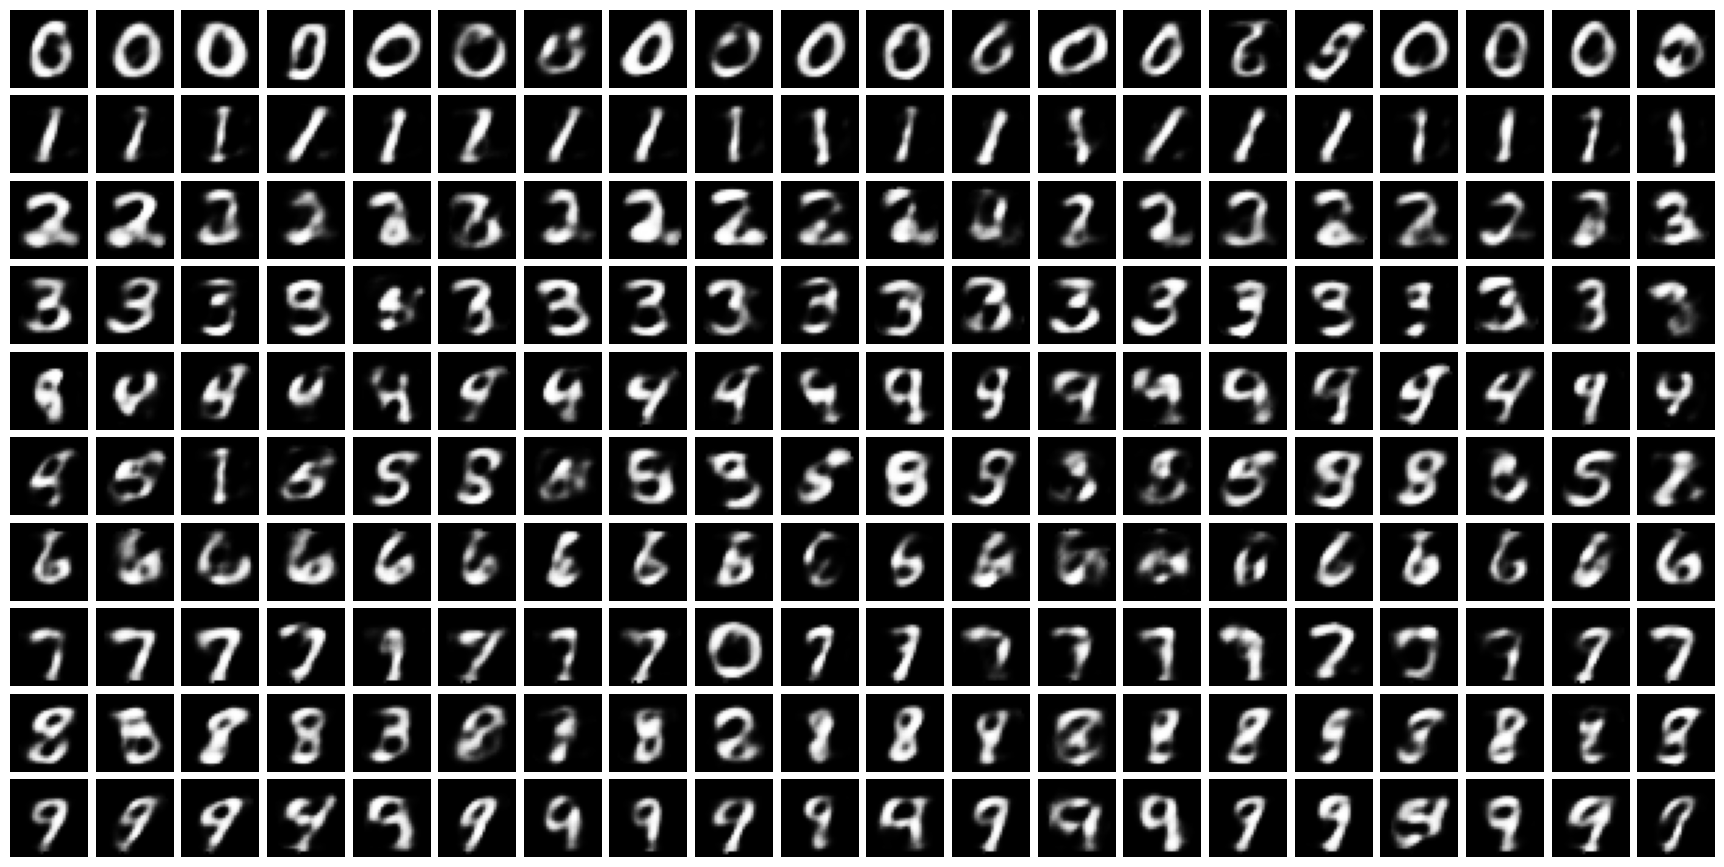

In [26]:
generation_dict = defaultdict(list)
for label,prediction in zip(labels_generation_egs,generation_preds_raw_first):
    image = prediction.split(".")[0].split(":")[-1]
    generation_dict[label].append(image)
reconlist_first,plt_first = plot_all_predictions(generation_dict, vqvae_model, max_plots_per_digit=20)
plt_first.savefig("generation_plot_ckpt_500.png")
plt_first.show()

## Plot generations for model from iteration 5000

In [27]:
model,encode,decode = setup_model_and_meta("./nanoGPT/out-mnist-vlm/","ckpt_5000.pt")
generation_preds_raw_last = multi_prompt_sampling(model, masked_generation_egs,encode,decode)

number of parameters: 14.18M


Processing examples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:12<00:00, 13.79it/s]


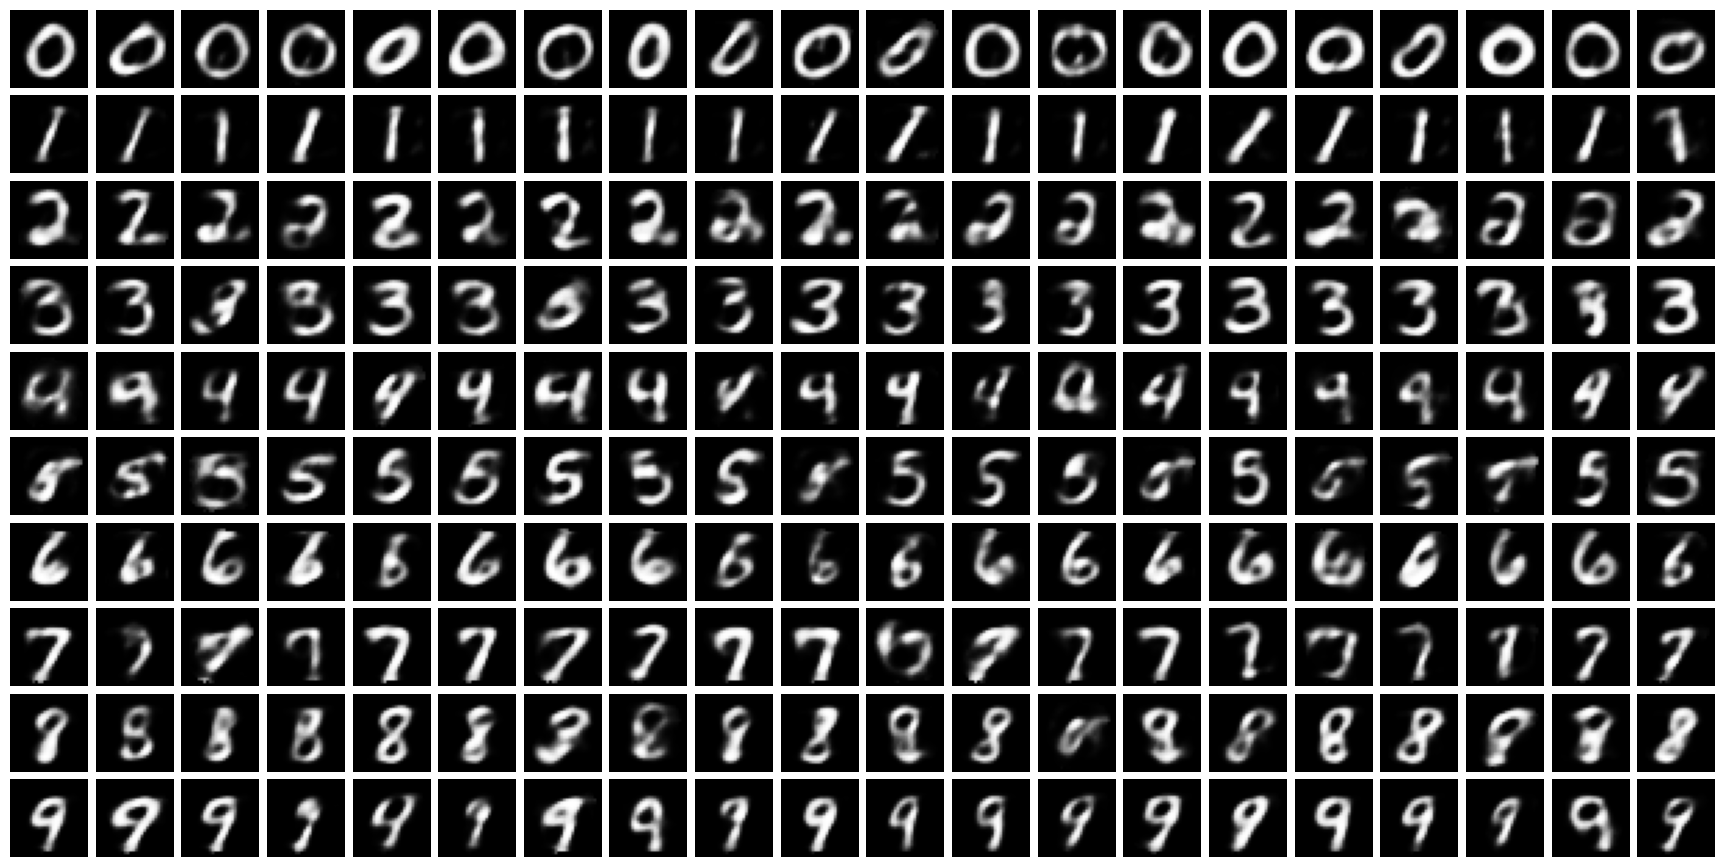

In [28]:
generation_dict = defaultdict(list)
for label,prediction in zip(labels_generation_egs,generation_preds_raw_last):
    image = prediction.split(".")[0].split(":")[-1]
    generation_dict[label].append(image)
reconlist_last, plt_last = plot_all_predictions(generation_dict, vqvae_model, max_plots_per_digit=20)
plt_last.savefig("generation_plot_ckpt_5000.png")
plt_last.show()